In [1]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import warnings
import os

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-10-29 19:11:41.621096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 19:11:42.339581: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data

In [2]:
max_zeros_pct = 0.3
window_size = 3
sequence_length = 10

df = load_and_merge()
df = remove_underpopulated_taxa(df, max_zeros_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [3]:
df

,364179,189384,865469,585419,564806,309391,682726,3154070,553611,262095,...,193484,577170,359650,193233,196664,583117,354850,subject_id,sampling_day,ind_time
E000823.4.0,0.000160,0.100671,0.002424,0.000379,0.113394,0.000000,0.149880,0.000327,0.018368,0.034098,...,0.000000,0.122840,0.000000,0.040201,0.059699,0.010154,0.064039,E000823,0.072046,0.072046
E000823.5.0,0.000160,0.120805,0.000958,0.000632,0.117647,0.000000,0.161871,0.000491,0.015911,0.038716,...,0.000000,0.155183,0.000000,0.035804,0.054162,0.010779,0.029557,E000823,0.100865,0.100865
E000823.5.7,0.000180,0.053691,0.000620,0.058665,0.089668,0.000000,0.203837,0.000981,0.016023,0.081743,...,0.000000,0.115150,0.000000,0.034338,0.060045,0.009685,0.019704,E000823,0.121037,0.121037
E000823.6.7,0.000160,0.080537,0.159159,0.135397,0.062047,0.053140,0.206235,0.000654,0.012226,0.098214,...,0.038943,0.071113,0.000000,0.021566,0.035127,0.006092,0.000000,E000823,0.149856,0.149856
E000823.8.5,0.000220,0.053691,0.158651,0.136450,0.046781,0.053140,0.197842,0.007195,0.010887,0.093596,...,0.038943,0.083439,0.000000,0.050251,0.061602,0.037334,0.000000,E000823,0.201729,0.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.080890,0.503356,0.038563,0.005180,0.008506,0.015700,0.308153,0.007032,0.000056,0.024708,...,0.012517,0.288137,0.536697,0.091290,0.127531,0.423113,0.068966,E014086,0.832853,0.832853
E014086.32.4,0.120524,0.711409,0.077127,0.006233,0.005103,0.028986,0.130695,0.011284,0.000000,0.014778,...,0.033380,0.426464,0.653670,0.142169,0.345042,0.622876,0.285714,E014086,0.890490,0.890490
E014086.33.5,0.141802,0.906040,0.098213,0.005728,0.005238,0.033816,0.116307,0.021913,0.000000,0.011469,...,0.043115,0.507480,0.597477,0.213358,0.537809,0.756436,0.507389,E014086,0.922190,0.922190
E014086.34.4,0.127490,0.899329,0.063201,0.001558,0.003760,0.032609,0.049161,0.028618,0.000000,0.006542,...,0.040334,0.571745,0.582569,0.241625,0.631597,0.749125,0.610837,E014086,0.948127,0.948127


## Features and targets

In [4]:
number_test_sequences = 3

train_feats, train_targets, test_feats, test_targets, test_subjects = feats_and_targets(df, seq_length=sequence_length, n_test_seq=number_test_sequences)

The test subjects are ['E001958' 'E003188' 'E004628']


In [5]:
print(len(train_feats), len(train_targets))

270 270


In [6]:
train_targets = np.asarray(train_targets)
train_targets = pd.DataFrame(train_targets)
train_targets.columns = df.columns[:-1]

In [7]:
train_targets

,364179,189384,865469,585419,564806,309391,682726,3154070,553611,262095,...,997439,193484,577170,359650,193233,196664,583117,354850,subject_id,sampling_day
0,0.000280,0.214765,0.197215,0.001137,0.006715,0.136473,0.058753,0.000818,0.003126,0.006158,...,0.001766,0.265647,0.133902,0.697248,0.016960,0.045510,0.301300,0.049261,0.608069,0.608069
1,0.124067,0.060403,0.011783,0.005896,0.003358,0.016908,0.160671,0.098774,0.007983,0.003772,...,0.043079,0.020862,0.038559,0.145642,0.239112,0.128742,0.005436,0.004926,0.792507,0.792507
2,0.001061,0.208054,0.004567,0.001306,0.016474,0.079710,0.061151,0.158790,0.000000,0.111453,...,0.000000,0.129346,0.182575,0.391055,0.289154,0.246929,0.252312,0.211823,0.951009,0.951009
3,0.000280,0.006711,0.024525,0.017351,0.007566,0.091787,0.019185,0.095830,0.000558,0.001770,...,0.010946,0.057024,0.108302,0.110092,0.409338,0.133068,0.100662,0.236453,0.582133,0.582133
4,0.023440,0.020134,0.008908,0.002653,0.011684,0.047101,0.028777,0.005724,0.000335,0.007466,...,0.002119,0.105702,0.022545,0.088303,0.088777,0.118013,0.206823,0.024631,0.907781,0.907781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.120524,0.711409,0.077127,0.006233,0.005103,0.028986,0.130695,0.011284,0.000000,0.014778,...,0.002472,0.033380,0.426464,0.653670,0.142169,0.345042,0.622876,0.285714,0.890490,0.890490
266,0.000280,0.006711,0.158990,0.021226,0.009401,0.073671,0.035971,0.089616,0.003796,0.004233,...,0.014124,0.054242,0.129056,0.143349,0.471524,0.165946,0.124406,0.330049,0.616715,0.616715
267,0.166924,0.234899,0.017647,0.002190,0.034112,0.670290,0.050360,0.139330,0.000223,0.108990,...,0.071328,0.723227,0.067741,0.602064,0.193886,0.139817,0.054424,0.049261,0.766571,0.766571
268,0.025742,0.107383,0.005074,0.001642,0.003044,0.038647,0.011990,0.194930,0.004187,0.002848,...,0.019068,0.016690,0.068479,0.084862,0.220268,0.076484,0.008435,0.019704,0.858790,0.858790


## The model

In [8]:
def fetch_model(seq_length):

    reg = 1e-8
    
    n_feats = len(df.columns) - 1
    
    model = Sequential()
    model.add(keras.Input(shape=(seq_length, n_feats)))
    model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
    model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(128, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(1, activation="relu"))
    
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    
    return model

In [9]:
def compile_model(model, loss):
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    return model

In [10]:
#model = fetch_model()
#
#model.summary()
#
#model.save("/home/nate/temp/test_model_save.model")

## Individual model testbench

In [11]:
y_true = tf.constant([0])
y_pred = tf.constant([1])

loss = mae_ignore_zeros(false_positives_penalty_factor=0.3)
loss.call(y_true, y_pred)

2023-10-29 19:11:44.615461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 19:11:44.631493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 19:11:44.631755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<tf.Tensor: shape=(), dtype=float64, numpy=nan>

In [12]:
target_taxa = 364179

plot=False

if plot is True:
    plot_a_taxa_sequence(train_targets[target_taxa], title=f"Train sequence for taxa_idx {target_taxa}", color="blue")

In [13]:
n_epochs = 15

#loss = mae_ignore_zeros(false_positives_penalty_factor=0.3)
loss = "mae"

model = fetch_model(seq_length=sequence_length)
model = compile_model(model, loss)

model.fit(x=train_feats, y=train_targets[target_taxa], validation_split=0.05, epochs=n_epochs, verbose=1)

Epoch 1/15


2023-10-29 19:11:46.830000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-29 19:11:46.859335: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fec8c008d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-29 19:11:46.859366: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-10-29 19:11:46.864444: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-29 19:11:46.877776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-29 19:11:46.979724: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

8/8 [==============================] - 2s 39ms/step - loss: 7.6874 - mae: 0.0272 - mape: 139753.6875 - val_loss: 6.2360 - val_mae: 0.0396 - val_mape: 85.7143
Epoch 2/15
8/8 [==============================] - 0s 14ms/step - loss: 5.2755 - mae: 0.0264 - mape: 94.9219 - val_loss: 4.1916 - val_mae: 0.0396 - val_mape: 85.7143
Epoch 3/15
8/8 [==============================] - 0s 13ms/step - loss: 3.4991 - mae: 0.0264 - mape: 94.9219 - val_loss: 2.7385 - val_mae: 0.0396 - val_mape: 85.7143
Epoch 4/15
8/8 [==============================] - 0s 15ms/step - loss: 2.2607 - mae: 0.0264 - mape: 94.9219 - val_loss: 1.7516 - val_mae: 0.0396 - val_mape: 85.7143
Epoch 5/15
8/8 [==============================] - 0s 14ms/step - loss: 1.4326 - mae: 0.0264 - mape: 94.9219 - val_loss: 1.1059 - val_mae: 0.0396 - val_mape: 85.7143
Epoch 6/15
8/8 [==============================] - 0s 17ms/step - loss: 0.8977 - mae: 0.0264 - mape: 94.9219 - val_loss: 0.6960 - val_mae: 0.0396 - val_mape: 85.7143
Epoch 7/15
8/8 [=

In [14]:
test_subjects

array(['E001958', 'E003188', 'E004628'], dtype=object)

In [15]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

test_subject_feats = np.asarray(test_feats[target_subject])

test_subject_targets = pd.concat(test_targets[target_subject]).T
test_subject_targets.columns = df.columns[:-1]

1/1 [==============================] - 0s 129ms/step


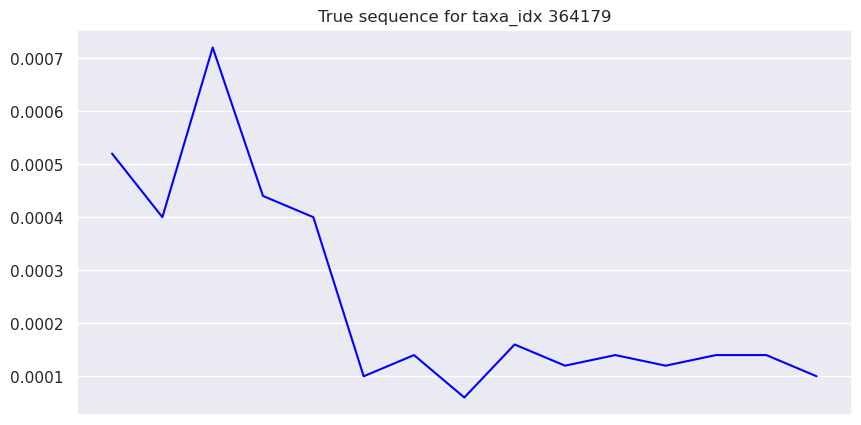

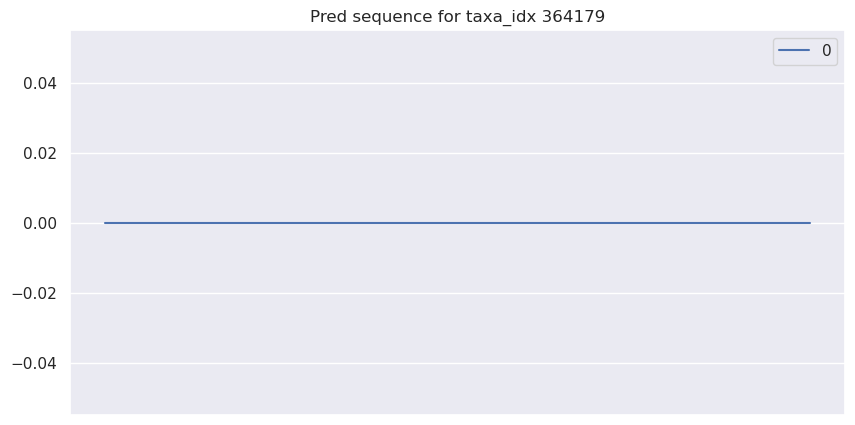

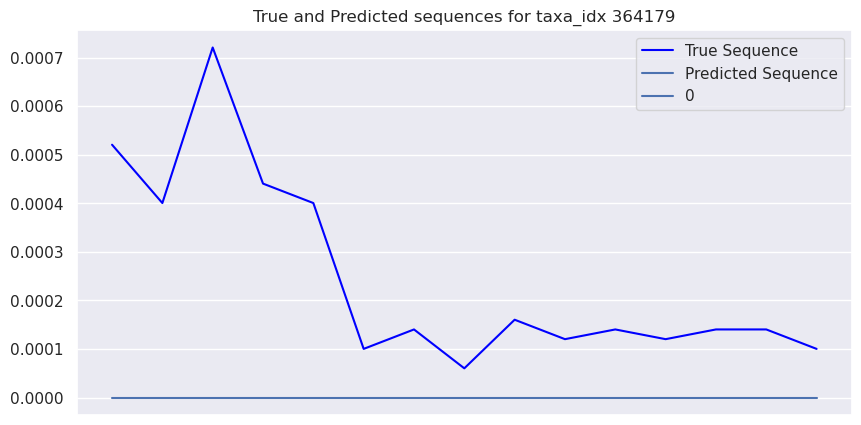

In [16]:
y_pred = model.predict(test_subject_feats)

true_sequence = test_subject_targets[target_taxa].reset_index(drop=True)
pred_sequence = y_pred

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

## The Ensemble

In [17]:
class ensemble():
        
    def __init__(self, ensemble_name, loss, seq_length, overwrite_on_train=False):
        
        self.models_out_dir = f"{root_dir}/models/{ensemble_name}"
        self.overwrite_on_train = overwrite_on_train
        self.loss = loss
        self.seq_length = seq_length

        
    def train(self, X_sequences_train, y_targets_train, n_epochs):
        
        # hardcoded stuff
        ignore_cols = ["subject_id", "sampling_day", "ind_time"]
        
        if not os.path.exists(self.models_out_dir):
            os.mkdir(self.models_out_dir)
        else:
            if self.overwrite_on_train is False:
                raise Exception("This model dir already exists")
            else:
                print("Overwriting an existing model dir")
                shutil.rmtree(self.models_out_dir)
                os.mkdir(self.models_out_dir)
                
        for taxa_idx in tqdm(y_targets_train.columns, desc="Training models"):
            
            if taxa_idx not in ignore_cols:
            
                model = fetch_model(seq_length=self.seq_length)
                model = compile_model(model, loss)
                y_targets = y_targets_train[taxa_idx]
                model.fit(x=X_sequences_train, y=y_targets, validation_split=0.05, epochs=n_epochs, verbose=0)
                
                model.save(f"{self.models_out_dir}/{taxa_idx}.model")
            
                del model
            
    
    def load(self):
        
        self.model_dic = {}

        for model_dir in tqdm(os.listdir(self.models_out_dir), desc="Loading the models"):
            taxa_idx = int(model_dir.replace(".model", ""))
            
            if isinstance(loss, mae_ignore_zeros):
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model", compile=False)
                model = compile_model(model, loss)
            else:
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model")
                 
            self.model_dic[taxa_idx] = model
    
         
    def predict(self, X_sequences):
        
        self.load()
        
        n_sequences = len(X_sequences)
        
        pred_list = []
        for taxa_idx in tqdm(self.model_dic.keys(), desc="Predicting values"):
            model = self.model_dic[taxa_idx]
            pred_list.append(model.predict(X_sequences, verbose=0).reshape(n_sequences,))
            del(model)
            
        pred_df = pd.DataFrame(pred_list).T
            
        return pred_df

In [18]:
# Tensorflow does not play nice with my Linux machine, thus I am filtering out its warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#loss = mae_ignore_zeros(false_positives_penalty_factor=0.1)
loss = "mae"

model_ensemble = ensemble(ensemble_name="test_ensemble", loss=loss, overwrite_on_train=True, seq_length=sequence_length)

In [19]:
train_targets

,364179,189384,865469,585419,564806,309391,682726,3154070,553611,262095,...,997439,193484,577170,359650,193233,196664,583117,354850,subject_id,sampling_day
0,0.000280,0.214765,0.197215,0.001137,0.006715,0.136473,0.058753,0.000818,0.003126,0.006158,...,0.001766,0.265647,0.133902,0.697248,0.016960,0.045510,0.301300,0.049261,0.608069,0.608069
1,0.124067,0.060403,0.011783,0.005896,0.003358,0.016908,0.160671,0.098774,0.007983,0.003772,...,0.043079,0.020862,0.038559,0.145642,0.239112,0.128742,0.005436,0.004926,0.792507,0.792507
2,0.001061,0.208054,0.004567,0.001306,0.016474,0.079710,0.061151,0.158790,0.000000,0.111453,...,0.000000,0.129346,0.182575,0.391055,0.289154,0.246929,0.252312,0.211823,0.951009,0.951009
3,0.000280,0.006711,0.024525,0.017351,0.007566,0.091787,0.019185,0.095830,0.000558,0.001770,...,0.010946,0.057024,0.108302,0.110092,0.409338,0.133068,0.100662,0.236453,0.582133,0.582133
4,0.023440,0.020134,0.008908,0.002653,0.011684,0.047101,0.028777,0.005724,0.000335,0.007466,...,0.002119,0.105702,0.022545,0.088303,0.088777,0.118013,0.206823,0.024631,0.907781,0.907781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.120524,0.711409,0.077127,0.006233,0.005103,0.028986,0.130695,0.011284,0.000000,0.014778,...,0.002472,0.033380,0.426464,0.653670,0.142169,0.345042,0.622876,0.285714,0.890490,0.890490
266,0.000280,0.006711,0.158990,0.021226,0.009401,0.073671,0.035971,0.089616,0.003796,0.004233,...,0.014124,0.054242,0.129056,0.143349,0.471524,0.165946,0.124406,0.330049,0.616715,0.616715
267,0.166924,0.234899,0.017647,0.002190,0.034112,0.670290,0.050360,0.139330,0.000223,0.108990,...,0.071328,0.723227,0.067741,0.602064,0.193886,0.139817,0.054424,0.049261,0.766571,0.766571
268,0.025742,0.107383,0.005074,0.001642,0.003044,0.038647,0.011990,0.194930,0.004187,0.002848,...,0.019068,0.016690,0.068479,0.084862,0.220268,0.076484,0.008435,0.019704,0.858790,0.858790


In [20]:
#model_ensemble.train(X_sequences_train=train_feats, y_targets_train=train_targets, n_epochs=15)

## Validation

In [21]:
test_subjects

array(['E001958', 'E003188', 'E004628'], dtype=object)

In [22]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

target_subject_y_test_df = pd.concat(test_targets[target_subject]).T
target_subject_y_test_df.columns = df.columns[:-1]

target_subject_y_test_df = target_subject_y_test_df.reset_index(drop=True)
target_subject_y_test_df

0      0.000520
1      0.315436
2      0.163669
3      0.041693
4      0.029949
         ...   
1210   0.021457
1211   0.068889
1212   0.507389
1213   0.994236
1214   0.994236
Length: 1215, dtype: float64

In [23]:
target_subject_feats = test_feats[target_subject]

In [24]:
target_subject_y_pred_df = model_ensemble.predict(target_subject_feats)
target_subject_y_pred_df = target_subject_y_pred_df.reset_index(drop=True)
target_subject_y_pred_df.columns = target_subject_y_test_df.columns

Predicting values:   0%|          | 0/79 [00:00<?, ?it/s]


ValueError: in user code:

    File "/home/nate/anaconda3/envs/tu_medical/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/nate/anaconda3/envs/tu_medical/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nate/anaconda3/envs/tu_medical/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/nate/anaconda3/envs/tu_medical/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/nate/anaconda3/envs/tu_medical/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/nate/anaconda3/envs/tu_medical/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential_1" expects 1 input(s), but it received 15 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:12' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:13' shape=(None, 81) dtype=float32>, <tf.Tensor 'IteratorGetNext:14' shape=(None, 81) dtype=float32>]


In [ ]:
target_subject_y_pred_df

In [ ]:
non_predicted_cols = [col for col in target_subject_y_pred_df.columns if all(target_subject_y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(target_subject_y_pred_df.columns)) * 100}% of all taxa")

In [ ]:
target_taxa = 585419

true_sequence = target_subject_y_pred_df[target_taxa].reset_index(drop=True)
pred_sequence = target_subject_y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

In [ ]:
errors_df = calculate_percentage_errors(target_subject_y_pred_df, target_subject_y_test_df)
errors_df.describe()

In [ ]:
percentile_graph(errors_df, "accross all taxa", y_top_lim=2)

In [ ]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

In [ ]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa LSTM sequence on Float", y_top_lim=1)